# Описание проекта

- [x] Обработка данных с помощью pandas.
- [x] Веб-скреппинг(Selenium).
- [x] Работа с REST API (XML/JSON).
- [x] Визуализация данных.
- [x] Математические возможности Python (содержательное использование numpy/scipy, SymPy и т.д. для решения математических задач).
- [x] Streamlit.
- [x] SQL.
- [x] Работа с геоданными с помощью geopandas, shapely, folium и т.д.
- [x] Машинное обучение (построение предсказательных моделей типа регрессий или решающих деревьев).
- [x] Дополнительные технологии (библиотеки, не обсуждавшиеся в ходе курса — например, телеграм-боты, нейросети или ещё что-нибудь).

# Подготовка к работе с данными:

Установка Selenium WebDriver с браузером Chromium.

Shell script для настройки машины, предоставляемой Google Colab,
взят с [сайта](https://webdata360.com/blog/steps-to-install-selenium-in-google-colab/).

In [ ]:
%%shell

# Add debian buster
#This section adds the Debian Buster repository to the sources.list.d file.
cat > /etc/apt/sources.list.d/debian.list <<'EOF'

deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF


# Add keys
# This section adds the necessary keys for the Debian Buster repository.

apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
# This section sets the preferences for the Debian repository, specifically for chromium* packages.

cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium browser and driver
# This section updates the package list and installs the chromium browser and chromium driver.

apt-get update
apt-get install chromium chromium-driver
pip install selenium

Устанавливаем все необходимые библиотеки и зависимости

In [ ]:
!pip install yfinance
!pip install geopandas
!pip install tqdm

Импортируем всё, что нужно для дельнейшей работы

In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By

import csv
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

Устанавливаем параметры драйвера чтобы selenium нормально запускался

In [15]:
def web_driver():
    options = webdriver.ChromeOptions()
    # make sure the --verbose option is the first argument
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    # the chrome in linux only supports headless browser
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--disable-dev-shm-usage')

    return webdriver.Chrome(options=options)

In [16]:
driver = web_driver()

# Сбор, визуализация и общая подготовка данных

Достаём сокращённые названия акций (tickers) из топа Википедии с помощью веб-скреппинга и selenium

In [ ]:
import os
os.makedirs('cache', exist_ok=True)

In [ ]:
url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
driver.get(url)

In [18]:
table_proxy = driver.find_element(By.XPATH, '//table[@class="wikitable sortable jquery-tablesorter"]')
table_content = table_proxy.text

In [19]:
table_lines = table_content.split('\n')[1:]
snp500_tickers_titles = []
for line in table_lines:
  snp500_tickers_titles.append(line.split(' ')[0])

snp500_tickers_titles.sort()
snp500_tickers = list(map(lambda ticker: yf.Ticker(ticker), snp500_tickers_titles))

По найденным ticker'ам достаём через yfinance ежедневные данные об акциях (стоимости на момент открытия и закрытия торгов, минимальная и максимальная стоимость в течение заданного промежутка)

In [21]:
def fetch_tickers_data(tickers: list, start_date: datetime, end_date: datetime):
  data = yf.download(tickers, start_date, end_date)
  return data

In [80]:
#можем выбрать любой интересующий нас промежуток
time_period = (
    datetime.fromisoformat('2023-01-01'),
    datetime.fromisoformat('2023-06-01'),
)

tickers_data = fetch_tickers_data(snp500_tickers_titles, *time_period)

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


In [23]:
tickers_data.head()

Adj Close                                             \
                              A    AAL         AAP        AAPL        ABBV   
Date                                                                         
2023-01-03 00:00:00  149.795959  12.74  149.666672  124.706833  159.384705   
2023-01-04 00:00:00  151.423325  13.59  150.012344  125.993095  160.670532   
2023-01-05 00:00:00  151.862610  13.99  151.266647  124.656982  160.474228   
2023-01-06 00:00:00  147.429825  14.18  152.116013  129.243622  163.477783   
2023-01-09 00:00:00  147.230148  14.61  150.377762  129.772079  158.677979   

                                                                    \
                            ABC         ABT       ACGL         ACN   
Date                                                                 
2023-01-03 00:00:00  163.316559  108.543640  62.459999  268.106232   
2023-01-04 00:00:00  161.904968  110.158218  62.770000  267.193542   
2023-01-05 00:00:00  162.113739  109.752098  62.939999  260.884247   
2023-01-06 00:00:00  164.728149  111.267632  63.900002  267.064545   
2023-01-09 00:00:00  163.992523  111.089333  62.669998  271.568390   

                                 ...   Volume                              \
                           ADBE  ...     WYNN      XEL       XOM     XRAY   
Date                             ...                                        
2023-01-03 00:00:00  336.920013  ...  3318600  2684500  15146200  1653800   
2023-01-04 00:00:00  341.410004  ...  5743600  2265900  18058400  3697800   
2023-01-05 00:00:00  328.440002  ...  2983000  2104500  15946600  4455700   
2023-01-06 00:00:00  332.750000  ...  2901900  2976200  16348100  2058700   
2023-01-09 00:00:00  341.980011  ...  2751000  2707800  17964600  1468900   

                                                                          
                         XYL      YUM      ZBH    ZBRA     ZION      ZTS  
Date                                                                      
2023-01-03 00:00:00   812400  2307100   921100  295400  1175800  1840600  
2023-01-04 00:00:00   905900  1139400  1389400  311600  1689000  1796100  
2023-01-05 00:00:00  1295700  1078200  2238300  368200   867800  1560900  
2023-01-06 00:00:00   636200  1559400  2348900  552700  1363700  1761200  
2023-01-09 00:00:00  1224700  1211200  1423600  535400   902700  1700500  

[5 rows x 3018 columns]

In [85]:
## Streamlit cache
tickers_data.to_csv('cache/tickers_data.csv')

In [25]:
# промежуточные данные для анализа количества пропусков
df_close = tickers_data.isnull().sum()['Adj Close'][tickers_data.isnull().sum()['Adj Close'] > 0]
df_vol = tickers_data.isnull().sum()['Volume'][tickers_data.isnull().sum()['Volume'] > 0]

Самым информативным будет отображение распределения оценочной стоимости всех акций. Попробуем для него построить график *pie*, с помощью которого удобно выводить доли частей от общего количества.

In [26]:
# удаляем стобцы с пустыми значениями в 'Adj Close'
drop = [('Adj Close', x) for x in df_close.index]

drop_indices = list(map(lambda data: snp500_tickers_titles.index(data[1]), drop))
# индексы оставшихся тикеров
cleaned_indices = np.delete(np.arange(len(snp500_tickers)), drop_indices)

# сохраняем общее число акций для каждого тикера
# если 'sharesOutstanding' нет, то удаляем этот тикер
tickers_shares = []
shareless_indices = []
for idx in cleaned_indices:
  tickers_title = snp500_tickers_titles[idx]
  info = snp500_tickers[idx].info
  shares = info.get('sharesOutstanding')
  if not shares:
    shareless_indices.append(idx)
    drop.append(('Adj Close', tickers_title))
  else:
    tickers_shares.append(shares)

cleaned_indices = np.delete(cleaned_indices, shareless_indices)
cleaned_data = tickers_data.drop(drop, axis = 1)

In [27]:
# подсчет оценочной стоимости и сортировка
caps = cleaned_data.mean()['Adj Close'] * tickers_shares
caps.sort_values(inplace = True)

In [66]:
## Streamlit cache
caps.to_csv('cache/caps.csv')

Строим график

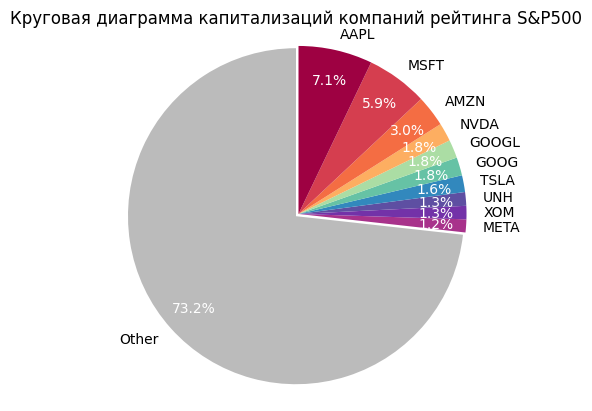

In [28]:
x = list(caps.values)
l = list(caps.index)

SLICE_NUM = 10
pie_x = [sum(x[:-SLICE_NUM]), *x[-SLICE_NUM:]]
pie_l = ['Other', *l[-SLICE_NUM:]]

colors = [
    '#bbbbbb', '#a8328b', '#7332a8', '#5e4fa2', '#3288bd', '#66c2a5', '#abdda4', '#fdae61', '#f46d43', '#d53e4f', '#9e0142',
]
fig, ax = plt.subplots()
ax.set_title("Круговая диаграмма капитализаций компаний рейтинга S&P500")
wedges, texts, percs = ax.pie(pie_x, labels=pie_l, startangle=90, autopct='%1.1f%%', pctdistance=0.82, colors=colors)
[autotext.set_color('white') for autotext in percs]

radfraction = 0.02
group = list(range(1, SLICE_NUM + 1))
ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
for j in group:
    center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
    wedges[j].set_center(center)
    text_offset = np.array(texts[j].get_position()) + center
    texts[j].set_position(1 * text_offset)
    percs[j].set_position(np.array(percs[j].get_position()) + center)
ax.autoscale(True)

plt.show()

In [29]:
## Streamlit cache
with open('cache/pie.csv', mode='w') as pie:
  employee_writer = csv.writer(pie, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  
  employee_writer.writerow(pie_l)
  employee_writer.writerow(pie_x)

Большинство ценных бумаг, представленных в списке, имеет малую долю в общей капитализации, и поэтому для дальнейшего анализа выбираем 10 крупнейших. 

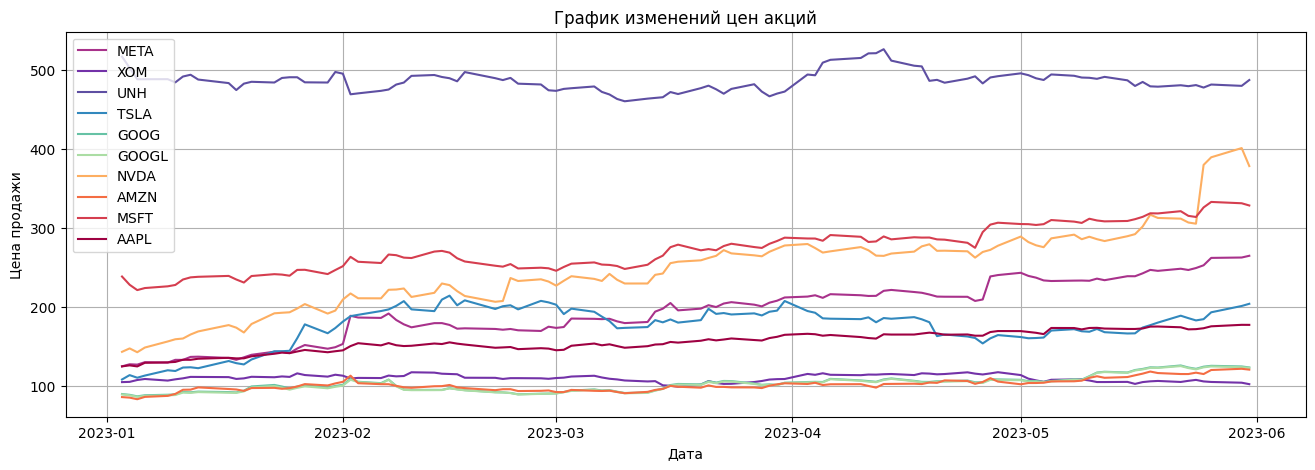

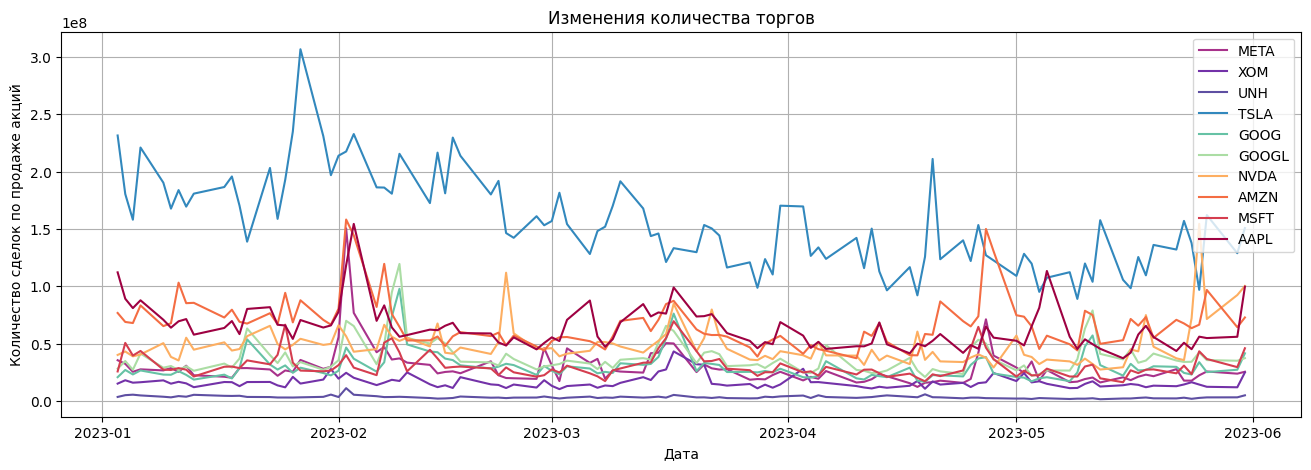

In [106]:
# отрисовка цен и объемов по времени
for y in ('Adj Close', 'Volume'):
  plt.figure(figsize = (16, 5))
  for idx, x in enumerate(caps[-10:].index):
    plt.plot(tickers_data.index, tickers_data[(y, x)], label = x, color=colors[1:][idx])
  plt.title('График изменений цен акций' if  y == 'Adj Close' else 'Изменения количества торгов')
  plt.xlabel("Дата")
  plt.ylabel('Цена продажи' if y == 'Adj Close' else 'Количество сделок по продаже акций')
  plt.legend()
  plt.grid(True)
  plt.show()

Для того, чтобы его сгладить и не потерять информативность, можно вывести график скользящего среднего.

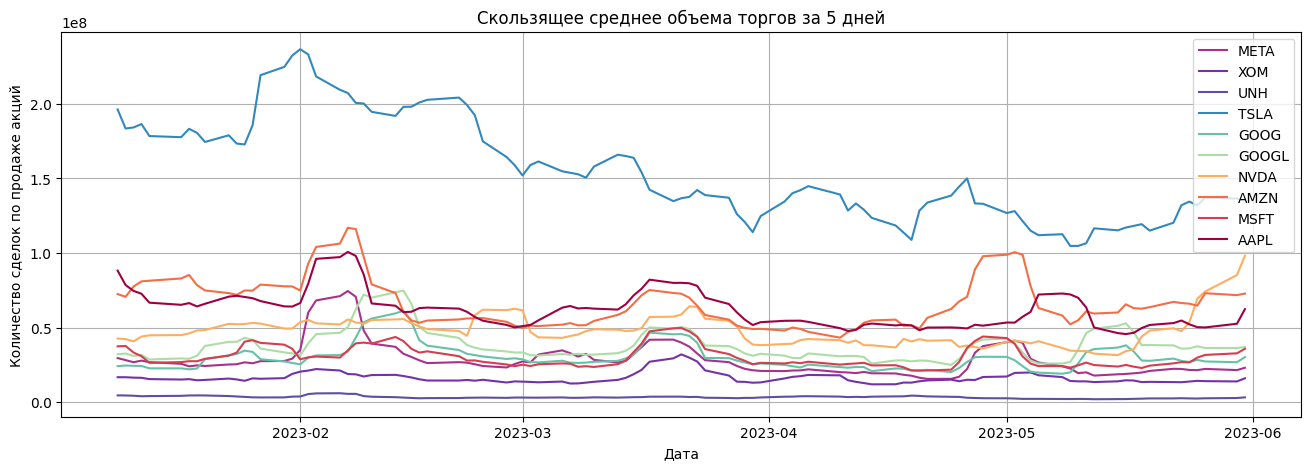

In [31]:
# скользящее среднее подсчитанно с помощью соответствующей оконной функции
window_size = 5
plt.figure(figsize = (16, 5))
for idx, x in enumerate(caps[-10:].index):
  plt.plot(tickers_data.index, tickers_data[('Volume', x)].rolling(window_size).agg(lambda r: r.mean()), label = x, color=colors[1:][idx])
plt.title('График изменений цен акций' if  y == 'Adj Close' else f'Скользящее среднее объема торгов за {window_size} дней')
plt.xlabel("Дата")
plt.ylabel('Цена продажи' if y == 'Adj Close' else 'Количество сделок по продаже акций')
plt.legend()
plt.grid(True)
plt.show()

В зависимости от параметра *window_size* можно регулировать степень сглаживания графика. Уже при *window_size=5* удается добиться неплохого сглаживания, при этом информация о тренде не теряется.

# Часть 1. Географическое распределение капитала
Первая часть проекта является скорее исследовательской, в рамках данной части происходит веб-скраппинг данных из Википедии (координат городов, в которых находятся компании-держатели акций), расчёт капитала компаний и отображение суммарного размера капиталов, сконцентрированных в определённых городах.

## Достаём координаты городов из википедии

Координаты приходят в формате строки вида "48°29′N 135°05′E" - функция coords_from_str переформатирует строку в список чисел типа float

In [32]:
def coords_from_str(coords: str):
  """Extract coorditanes data from wiki formated string"""
  out_list = []
  for angle in coords.split(' '):
    out_list.append(float(angle[:-2]))
    if angle.endswith('S') or angle.endswith('W'):
      out_list[-1] *= -1

  return out_list

Скреппинг происходит из википедии, у этого сервиса специфичные ссылки на города в США. 

Формата "wikipedia.org/wiki/Город **,_** Штат" - обязательно указывается название штата через запятую и нижнее подчёркивание, функция предназначена для скреппинга по городам США fetch_usa_city_coords учитывает этот нюанс.

In [33]:
def fetch_usa_city_coords(city: str, state: str):
  city = city.replace(' ', '_')
  driver.get(f'http://en.wikipedia.org/wiki/{city},_{state}')
  coords_proxy = driver.find_elements(By.XPATH, "//span[@class='geo-dec']")

  if len(coords_proxy) == 0:
    return ()
  scraped_coords = coords_proxy[0].get_attribute("textContent")
  return coords_from_str(scraped_coords)

In [34]:
def fetch_city_coords(city: str, country: str):
  city = city.replace(' ', '_')

  driver.get(f'http://en.wikipedia.org/wiki/{city}')
  coords_proxy = driver.find_elements(By.XPATH, "//span[@class='geo-dec']")

  if len(coords_proxy) == 0:
    country = country.replace(' ', '_')
    driver.get(f'http://en.wikipedia.org/wiki/{country}')
    button_proxy = driver.find_elements(By.LINK_TEXT, city)
    if len(button_proxy) == 0:
      return []
    button_proxy[0].click()
    coords_proxy = driver.find_elements(By.XPATH, "//span[@class='geo-dec']")

  if len(coords_proxy) == 0:
    return []
  scraped_coords = coords_proxy[0].get_attribute("textContent")
  return coords_from_str(scraped_coords)

In [35]:
from tqdm import tqdm

tickers_data_loc = {}
for idx, ticker in tqdm(enumerate(snp500_tickers), desc="Fetching tickers' locations"):
  info = ticker.info
  city = info.get('city')
  country = info.get('country')
  if not city or not country: continue

  if country == 'United States':
    coords = fetch_usa_city_coords(city, info.get('state'))
  else:
    coords = fetch_city_coords(city, country)

  if coords:
    tickers_data_loc.update({info.get('symbol'): [city, coords]})

Fetching tickers' locations: 503it [18:30,  2.21s/it]


## Считаем капитализацию по городам

In [36]:
# посчитали общую капитализацию по городам, закинули в dict вида {город: "названия акций", [координаты], капитализация}
def city_capitalization_count(caps, tickers_data_loc):

  city_to_capitalization = {}
  for ticker in tickers_data_loc:
    city_name = tickers_data_loc[ticker][0]
    if not city_name in city_to_capitalization and ticker in caps.keys():
      city_to_capitalization[city_name] = [ticker, tickers_data_loc[ticker][1], caps[ticker]]
    elif ticker in caps.keys():
      city_to_capitalization.update({city_name: [city_to_capitalization[city_name][0]+', '+ticker, tickers_data_loc[ticker][1], city_to_capitalization[city_name][2]+caps[ticker]]})

  return city_to_capitalization

In [37]:
# переформатируем чтобы всё красиво ложилось на карту
city_to_capitalization = city_capitalization_count(caps, tickers_data_loc)

lat, lon, cap = [], [], []
for capitalization in city_to_capitalization:
  lon.append(city_to_capitalization[capitalization][1][0])
  lat.append(city_to_capitalization[capitalization][1][1])
  cap.append(city_to_capitalization[capitalization][2]*0.000000001) # своего рода нормализация

## Рисуем карту

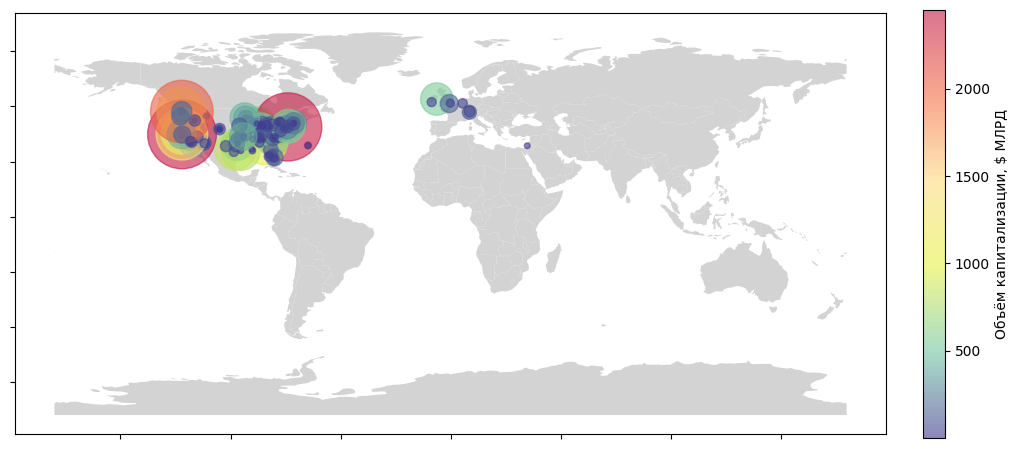

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 7))
worldmap.plot(color="lightgrey", ax=ax)

x, y, z = lat, lon, cap

cbar_colors = [
    (0.251, 0.224, 0.565),
    (0.439, 0.776, 0.635),
    (0.902, 0.945, 0.273),
    (0.992, 0.859, 0.498),
    (0.957, 0.427, 0.271),
    (0.763, 0.09, 0.271)
]
cbar_map = LinearSegmentedColormap.from_list('custom', cbar_colors)


plt.scatter(x, y, s=z, c=z, alpha=0.6, vmin=min(z), vmax=max(z),cmap=cbar_map)
plt.colorbar(label='Объём капитализации, $ МЛРД', fraction=0.023, pad=0.04)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.show()

In [39]:
## Streamlit cache
with open('cache/map.csv', mode='w') as map:
  employee_writer = csv.writer(map, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  
  employee_writer.writerow(x)
  employee_writer.writerow(y)
  employee_writer.writerow(z)

# Часть 2. Прогнозирование стоимости акций
Вторая часть проекта является более прикладной (с точки зрения применения результатов в реальной жизни). В рамках данной части происходит определение корреляции между различными экономическими показателями акций (стоимость на момент закрытия торгов, количество сделок продажи, количество) и построение модели регрессии.

## Корреляция

Берем один пример для того чтобы посмотреть на внешний вид данных

In [40]:
aapl = yf.Ticker('AAPL')
aapl.history(start = time_period[0], end = time_period[1], interval = '1h').head(8)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-01-03 09:30:00-05:00,130.279999,130.899994,125.230003,125.459999,27775505,0.0,0.0
2023-01-03 10:30:00-05:00,125.459999,125.870003,124.730003,125.345001,18104999,0.0,0.0
2023-01-03 11:30:00-05:00,125.350197,125.370003,124.349098,124.660004,11248777,0.0,0.0
2023-01-03 12:30:00-05:00,124.660004,124.940002,124.190002,124.649902,8860080,0.0,0.0
2023-01-03 13:30:00-05:00,124.669899,125.000000,124.190002,124.570000,8388062,0.0,0.0
2023-01-03 14:30:00-05:00,124.578003,125.330002,124.169998,124.620003,11718707,0.0,0.0
2023-01-03 15:30:00-05:00,124.629997,125.419998,124.625000,125.050003,10631332,0.0,0.0
2023-01-04 09:30:00-05:00,126.889999,127.555000,125.080002,125.998299,25459455,0.0,0.0


Подсчет корреляции для 10 крутых, между всеми параметрами (из таблицы выше)

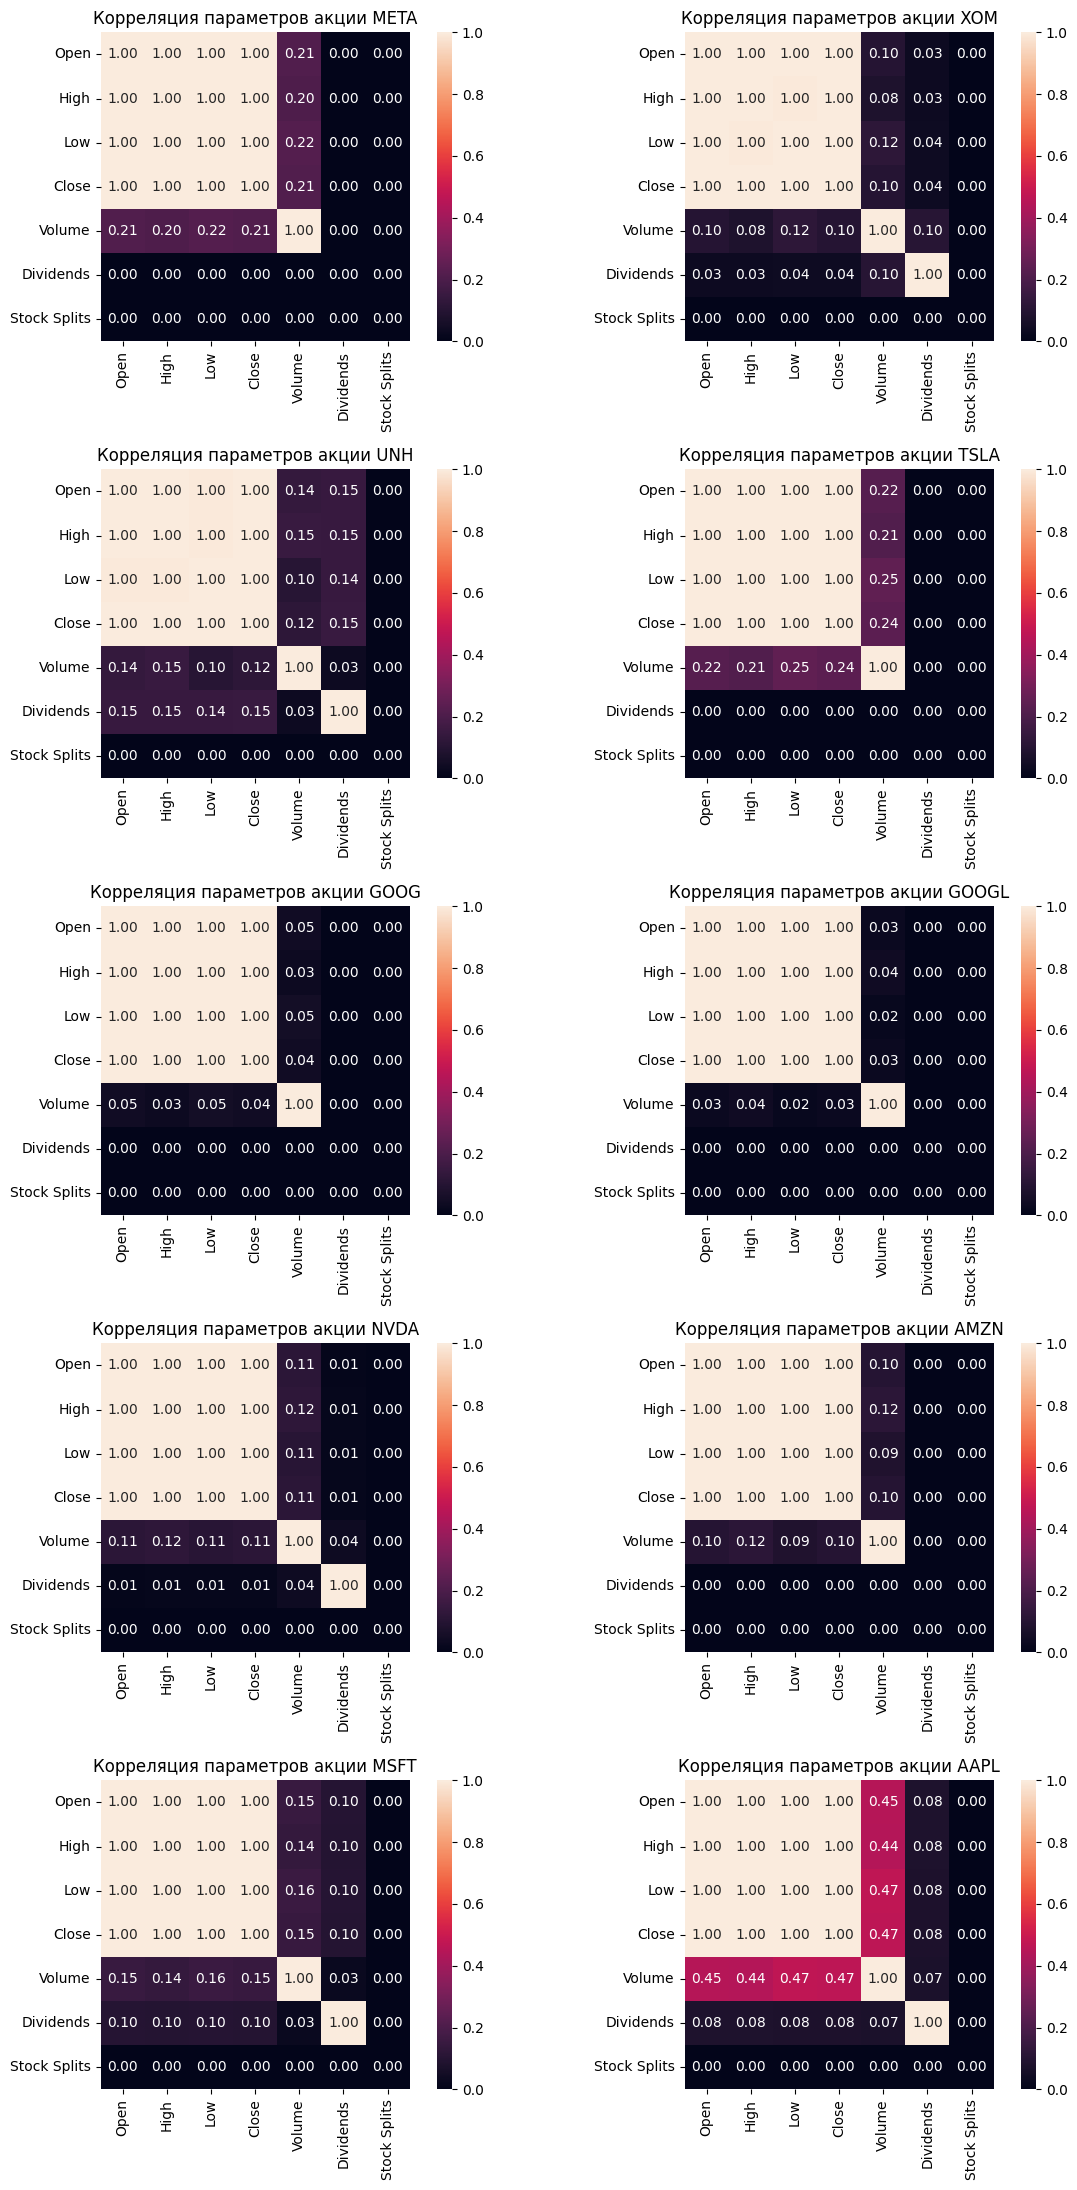

In [157]:
# подсчет корреляций
corr_samp = []
for ticker_name in caps[-10:].index: 
  ticker = yf.Ticker(ticker_name)
  ticker_data = ticker.history(start = time_period[0], end = time_period[1], interval = '1h')
  # в строке ниже есть 
  daily_ticker_data = ticker_data.rolling(7, step=7, center = False, min_periods=1).agg(lambda row: row.mean())
  corr_samp.append(daily_ticker_data.iloc[:, :7].corr().fillna(0).abs())

# отрисовка таблиц корреляции для нескольких акций
fig, axn = plt.subplots(ncols=2, nrows=5, figsize=(12,22), )
for i in range(len(axn)):
  for j in range(len(axn[i])):
    ax = plt.subplot(5, 2, i*2+j+1)
    ax.set_aspect('equal')
    sns.heatmap(corr_samp[i*2+j], annot = True, fmt=".2f")
    ax.set_title(f'Корреляция параметров акции {caps[-10:].index[i*2+j]}')

plt.tight_layout()
plt.savefig('corr.png')
plt.show()

Для построения модели регрессии для цен на закрытии (close) можно было использовать различные параметры цен акций, а также параметры дивидендов компаний и сплитов акций. К сожалению, почти все параметры (кроме volume) оказались либо линейно-зависимыми (все цены), либо неинформативными (весь признак периодически равен нулю, это признаки dividends, stock split). 

Тогда для предсказания цены будут использоваться предыдущие значения. Также можно дополнительно использовать volume.

## Регрессия



$$f(price_{\tau-n}, ..., price_{\tau}) \rightarrow price_{\tau+1}$$ 
$$f(price_{\tau-n}, ..., price_{\tau}, volume_{\tau-n}, ..., volume_{\tau}) \rightarrow price_{\tau+1}$$ 

Первая модель учитывает только предыдущие n измерений, вторая же будет дополняться еще и соответствующими параметрами volume.

In [43]:
# рассматривается акция, у которой относительно высокая корреляция между volume и price
nvda = yf.Ticker('NVDA')
nvda_data = nvda.history(start = time_period[0], end = time_period[1], interval = '1h')

# количество предыдущих измерений для построения модели 
n = 5

In [44]:
# преобразуем данные к стандартному виду Х, у
sh = (nvda_data.shape[0]-n-1, n+1)
data_matr = np.empty(sh)
for i in range(data_matr.shape[0]):
  data_matr[i] = nvda_data.iloc[i:i+n+1,3].values

X = data_matr[:, :-1]
y = data_matr[:, -1]

lin_regr = LinearRegression(n_jobs=-1)

# нормализуем данные и обучаем на них модель
X = (X - X.mean(axis = 0))/X.std(axis=0)
lin_regr.fit(X[:-10], y[:-10])

LinearRegression(n_jobs=-1)

In [45]:
y_test_pred = lin_regr.predict(X[-10:])

Теперь построим вторую модель регрессии с параметром volume и сравним результаты двух моделей. Поможет ли он улучшить качество модели? 

In [46]:
# также преобразуем данные к стандартному виду Х, у
sh = (nvda_data.shape[0]-n-1, 2*(n+1)-1)
data_matr = np.empty(sh)
for i in range(data_matr.shape[0]):
  data_matr[i, n:] = nvda_data.iloc[i:i+n+1,3].values
  data_matr[i, :n] = nvda_data.iloc[i:i+n,4].values

X_vol = data_matr[:, :-1]
y = data_matr[:, -1]

lin_regr_add_vol = LinearRegression(n_jobs=-1)

X_vol = (X_vol - X_vol.mean(axis = 0))/X_vol.std(axis=0)
lin_regr_add_vol.fit(X_vol[:-10], y[:-10])

LinearRegression(n_jobs=-1)

In [47]:
y_test_pred_vol = lin_regr_add_vol.predict(X_vol[-10:])

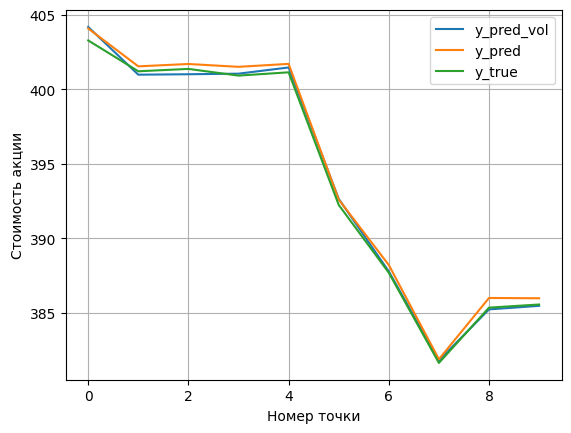

In [48]:
plt.plot(y_test_pred_vol, label = 'y_pred_vol')
plt.plot(y_test_pred, label = 'y_pred')
plt.plot(y[-11:-1], label = 'y_true')

plt.legend()
plt.ylabel('Стоимость акции')
plt.xlabel('Номер точки')
plt.grid(True)
plt.show()

In [49]:
## Streamlit cache
with open('cache/regression.csv', mode='w') as pie:
  employee_writer = csv.writer(pie, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  employee_writer.writerow(y_test_pred_vol)
  employee_writer.writerow(y_test_pred)
  employee_writer.writerow(y[-11:-1])

Использование признака volume действительно помогло значительно улучшить точность, однако и у первой модели довольно неплохое качество.

# Часть 3. Сохранение данных

Структура микро-БД:

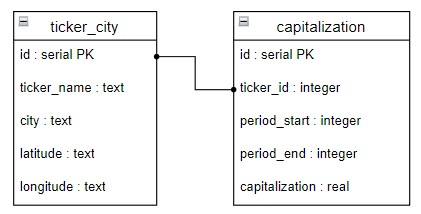

Создаём таблички, которые мы тут напридумывали выше

In [ ]:
import sqlite3

# ставим try-except.
try:
  conn = sqlite3.connect("database.sqlite")
  cur = conn.cursor()

  # создание таблички с тикером и городом+координатами 
  cur.execute("""
  CREATE TABLE ticker_city (
  id INTEGER PRIMARY KEY,
  ticker_name TEXT,
  city TEXT,
  latitude TEXT,
  longitude TEXT)
  """)

  # создание таблички с капитализацией за определённый период
  cur.execute("""
  CREATE TABLE capitalization (
  id INTEGER PRIMARY KEY,
  ticker_id INTEGER,
  period_start INTEGER,
  period_end INTEGER,
  capitalization REAL)
  """)
  cur.close()

except (Exception, sqlite3.DatabaseError) as error:
    print("DB error. Error creating tables: " + str(error))
finally:
    if conn is not None:
        conn.close()
        

Запускаем заполнение табличек из тех данных, которые мы насобирали и насчитали выше.

Глянуть правильно ли записываются данные можно, закинув файлик "database.sqlite" [сюда](https://inloop.github.io/sqlite-viewer/).

In [ ]:
# запись таблички ticker_city с тикерами, городами и координатами
try:
  conn = sqlite3.connect("database.sqlite")
  cur = conn.cursor()

  for tick in tickers_data_loc:
    ticker_info = tickers_data_loc[tick]
    cur.execute("INSERT INTO ticker_city (ticker_name, city, latitude, longitude) VALUES (?, ?, ?, ?)",
              (tick, ticker_info[0], str(ticker_info[1][0]), str(ticker_info[1][1])))

  conn.commit()
  cur.close()

except (Exception, sqlite3.DatabaseError) as error:
    print("DB error. Error filling ticker_city table: " + str(error))
finally:
    if conn is not None:
        conn.close()

In [ ]:
# запись таблички capitalization с капитализацией за период
try:
  conn = sqlite3.connect("database.sqlite")
  cur = conn.cursor()

  for tick in caps:
    # достаём id нужного нам тикера из таблички ticker_city (тк таблички связаны по этому id)
    cur.execute("SELECT id FROM ticker_city WHERE ticker_name = ?", (tick,))
    ticker_id = cur.fetchone()[0]

    
    cur.execute("INSERT INTO capitalization (ticker_id, period_start, period_end, capitalization) VALUES (?, ?, ?, ?)",
              (ticker_id, str(time_period[0].date()), str(time_period[1].date()), caps[tick]))

  conn.commit()
  cur.close()

except (Exception, sqlite3.DatabaseError) as error:
    print("DB error. Error filling ticker_city table: " + str(error))
finally:
    if conn is not None:
        conn.close()

Чтобы доставать капитализацию по определённому тикеру нужно делать join по ticker_id в (ticker_city+capitalization)

In [54]:
def get_loc_from_db():
  loc_db = []
  try:
    conn = sqlite3.connect("database.sqlite")
    cur = conn.cursor()

    # достаём id нужного нам тикера из таблички ticker_city (тк таблички связаны по этому id)
    cur.execute("SELECT * FROM ticker_city")
    loc_db = cur.fetchall()

    cur.close()

  except (Exception, sqlite3.DatabaseError) as error:
      print("DB error. Error getting capitalization from DB: " + str(error))
  finally:
      if conn is not None:
          conn.close()
      return loc_db

In [55]:
def format_tickers_data_loc(not_formatted_tickers_data_loc_DB):
  tickers = {}
  for tick in not_formatted_tickers_data_loc_DB:
    tickers[tick[1]] = [tick[2], [float(tick[3]), float(tick[4])]]

  return tickers

In [65]:
not_formatted_tickers_data_loc_DB = get_loc_from_db()
tickers_data_loc_DB = format_tickers_data_loc(not_formatted_tickers_data_loc_DB)